In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from numpy import linalg 
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from multiprocessing import Pool, cpu_count
import multiprocessing as mp
import time
import functools
from sklearn.preprocessing import OneHotEncoder

In [15]:
def distance(data, centroids):
    """ Calculate the distance from each data point to each center
    Parameters:
       data   n*d
       center k*d
    
    Returns:
       distence n*k 
    """
    ## calculate distence between each point to the centroids
    dist = np.sum((data[:, np.newaxis, :] - centroids)**2, axis=2)
    return dist
def cost(dist):
    """ Calculate the cost of data with respect to the current centroids
    Parameters:
       dist     distance matrix between data and current centroids
    
    Returns:    the normalized constant in the distribution 
    """
    return np.sum(np.min(dist,axis=1))

def distribution(dist,cost):
    """ Calculate the distribution to sample new centers
    Parameters:
       dist       distance matrix between data and current centroids
       cost       the cost of data with respect to the current centroids
    Returns:      distribution 
    """
    return np.min(dist, axis=1)/cost

def sample_new(data,distribution,l):
    """ Sample new centers
    
    Parameters:
       data         n*d
       distribution n*1
       l            the number of new centers to sample
    Returns:        new centers                          
    """
    return data[np.random.choice(range(len(distribution)),l,p=distribution),:]


In [16]:
def KMeans(data, k,  centroids, max_iter = 10000): 
    
    """ Apply the KMeans clustering algorithm
    
    Parameters:
      data                        ndarrays data 
      k                           number of cluster
      centroids                   initial centroids
    
    Returns:
      "Iteration before Coverge"  time used to converge
      "Centroids"                 the final centroids finded by KMeans    
      "Labels"                    the cluster of each data   
    """
    
    n = data.shape[0] 
    iterations = 0
    while iterations < max_iter:        
        dist = distance(data,centroids)
        
        ## give cluster label to each point 
        cluster_label = np.argmin(dist, axis=1)+1
        ## calculate new centroids
        newCentroids = np.zeros(centroids.shape)
        for j in range(1, k+1):
            if sum(cluster_label == j) == 0:
                newCentroids[j-1] = centroids[j-1]
            else:
                newCentroids[j-1] = np.mean(data[cluster_label == j, :], axis=0)
        
        ## Check if it is converged
        if np.array_equal(centroids, newCentroids):
            print("Converge! after:",iterations,"iterations")
            break 
            
        centroids = newCentroids
        iterations += 1
        
    return({"Iteration before Coverge": iterations, 
            "Centroids": centroids, 
            "Labels": cluster_label})

In [17]:
def KMeansPlusPlus(data, k):    
    """ Apply the KMeans++ clustering algorithm to get the initial centroids   
    Parameters: 
      data                        ndarrays data 
      k                           number of cluster  
    Returns:
      "Centroids"                 the complete initial centroids by KMeans++
      
    """
    
    #Initialize the first centroid
    centroids = data[np.random.choice(data.shape[0],1),:]
    
    while centroids.shape[0] < k :
                
        #Get the distance between data and centroids
        dist = distance(data, centroids)
        
        #Calculate the cost of data with respect to the centroids
        norm_const = cost(dist)
        
        #Calculate the distribution for sampling a new center
        p = distribution(dist,norm_const)
        
        #Sample the new center and append it to the original ones
        centroids = np.r_[centroids, sample_new(data,p,1)]
    
    return centroids

In [18]:
def get_weight(dist,centroids):
    min_dist = np.zeros(dist.shape)
    min_dist[range(dist.shape[0]), np.argmin(dist, axis=1)] = 1
    count = np.array([np.count_nonzero(min_dist[:, i]) for i in range(centroids.shape[0])])
    return count/np.sum(count)

def ScalableKMeansPlusPlus(data, k, l,iter=5):
    
    """ Apply the KMeans|| clustering algorithm
    
    Parameters:
      data     ndarrays data 
      k        number of cluster
      l        number of point sampled in each iteration
    
    Returns:   the final centroids finded by KMeans||  
      
    """
    
    centroids = data[np.random.choice(range(data.shape[0]),1), :]
    
    
    for i in range(iter):
        #Get the distance between data and centroids
        dist = distance(data, centroids)
        
        #Calculate the cost of data with respect to the centroids
        norm_const = cost(dist)
        
        
        #Calculate the distribution for sampling l new centers
        p = distribution(dist,norm_const)
        
        #Sample the l new centers and append them to the original ones
        centroids = np.r_[centroids, sample_new(data,p,l)]
    

    ## reduce k*l to k using KMeans++ 
    dist = distance(data, centroids)
    weights = get_weight(dist, centroids)
    return centroids[np.random.choice(len(weights), k, replace= False, p = weights),:]

In [66]:
def min_distance_index_p(d, centroids):
    
    """ Return the index of the minimum distance from point d 
        to its nearest center in centroids."""
    
    minInd = np.argmin(np.sum((centroids - d)**2, axis=1))
    return minInd 
def randomSample(x, a, p):
    np.random.seed()
    return np.random.choice(a = a, size = x , p =p)
def cost_p(data, centroids): 
    
    """ Calculate the cost of data with respect to 
    the current centroids and the new probability 
    distribution of each point for next sample"""   
    total_cost = 0
    mins = np.array([])
    chucks = np.array_split(data, 10)
    for i in range (10):        
        min_dist = (map(functools.partial(min_distance, centroids = centroids),chucks[i]))
        min_dist = np.fromiter( min_dist, dtype=np.float)
        cost = np.sum(min_dist)
        total_cost += cost
        mins = np.concatenate((mins,min_dist))
    p = mins/total_cost 
    
    '''   
     with Pool(processes = cpu_count()) as pool:
        partial_dist = partial(min_distance, centroids = centroids)
        min_dist = pool.map(partial_dist, data)
        cost = np.sum(min_dist)
        p = min_dist/cost
    '''
    return cost,p
def sample_new_p(data, distribution, l):
    """ Sample new centers""" 

    index = randomSample([1]*l,a = len(distribution), p=distribution)
    '''
    with Pool(processes = cpu_count()) as pool:
        partial_rc = partial(randomSample, a = len(distribution), p=distribution)
        index = pool.map(partial_rc,[1]*l)
    '''
    return np.squeeze(data[indexs,:],axis=(1,))
def min_distance(d, centroids):
    
    """ Calculate the minimum distance from point d 
        to its nearest center in centroids."""
    dist = np.min(np.sum((centroids - d)**2, axis=1))
    return dist

def get_weight_p(data, centroids):
    
    """ Return weight of all centroids """
    mins_index = np.array([])
    chucks = np.array_split(data, 10)    
    for i in range (10): 
        min_ind = (map(functools.partial(min_distance_index_p, centroids = centroids),chucks[i]))
        min_ind = np.fromiter( min_ind, dtype=np.float)
        mins_index = np.concatenate((mins_index, min_ind))
    count = np.array([np.sum(np.array(mins_index) == i) for i in range(centroids.shape[0])])
    '''
    with Pool(processes = cpu_count()) as pool:
        partial_minInd = partial(min_distance_index_p, centroids = centroids )
        min_index = pool.map(partial_minInd, data)
        count = np.array([np.sum(np.array(min_index) == i) for i in range(centroids.shape[0])])
    '''
    return count/np.sum(count)
def ScalableKMeansPlusPlus_p(data, k, l,weighted = False, iter=5):
    
    """ Apply the KMeans|| clustering algorithm"""
    
    centroids = data[np.random.choice(range(data.shape[0]),1), :]    
    
    for i in range(iter):   
        
        # Calculate the cost and new distribution
        norm_const = cost_p(data, centroids)[0]
        p = cost_p(data, centroids)[1] 
        
        # Sample the several(l) new centers and append them to the original ones
        centroids = np.r_[centroids, sample_new(data, p, l)]
        
    ## reduce k*l to k using KMeans++ 
    weights = get_weight_p(data,centroids)
    if weighted:
        initial = centroids[np.random.choice(range(len(weights)),k,replace=False),:]
        centers=  weightedKMeans(centroids, k, weights, initial)
    else: 
        centers= centroids[np.random.choice(len(weights), k, replace= False, p = weights),:]
    return centers

In [51]:

dataset = np.loadtxt ("s1.txt")
k = 15
ground_truth = np.loadtxt ("s1-cb.txt")
true_label = np.loadtxt ("s1-label.txt")

In [53]:
time1 = time.time()
centroid = dataset[np.random.choice(range(dataset.shape[0]), k, replace=False),:]
kmeans_result = KMeans (dataset,k,centroid)
time2 = time.time()
print ("Kmean took",time2-time1,"seconds to compute")
time1 = time.time()
kmeanspluplus_result = KMeansPlusPlus(dataset,k)
kmeanspluplus_result = KMeans (dataset,k,kmeanspluplus_result)
time2 = time.time()
print ("Kmeanplusplus took",time2-time1,"seconds to compute")
time1 = time.time()
result = ScalableKMeansPlusPlus (dataset,k,k*3)
result = KMeans (dataset,k,result)
time2 = time.time()
print ("scalable Kmeanplusplus took",time2-time1,"seconds to compute")
time1 = time.time()
parallelresult = ScalableKMeansPlusPlus_p (dataset,k,k*3)
time2 = time.time()
parallelresult = KMeans (dataset,k,parallelresult)
time3 = time.time()
print ("parallel scalable Kmeanplusplus took",(time2-time1)/10 + (time3-time2),"seconds to compute")

Converge! after: 20 iterations
Kmean took 3.974167823791504 seconds to compute
Converge! after: 19 iterations
Kmeanplusplus took 3.938655138015747 seconds to compute
Converge! after: 22 iterations
scalable Kmeanplusplus took 4.3770506381988525 seconds to compute
Converge! after: 11 iterations
parallel scalable Kmeanplusplus took 1.9763572216033936 seconds to compute
parallel scalable Kmeanplusplus took 2.0574836492538453 seconds to compute


In [55]:
def clusterCost(data,predict):
    dist = distance(data,predict["Centroids"])
    return cost(dist)/(10**4)

In [56]:
print("Clustering Cost:")
print("Random:", clusterCost(dataset, kmeans_result)) # Random 
print("KMeans++:",clusterCost(dataset, kmeanspluplus_result)) # KMeans++
print("Scalable KMeans++:", clusterCost(dataset, result)) # Scalable KMeans++

Clustering Cost:
Random: 2110894838.922279
KMeans++: 1329554444.3899662
Scalable KMeans++: 1355053188.3926153


In [59]:
def accuracyRate(trueLabels, predict,k,convert = False):
    """
    Calculate the misclassification rate of the algorithm
    
    Parameters:
    trueLabels   n*1 true labels of each observation  
    predict      n*1 predict labels of each observation 
    
    Returns:     misclassification rate 
    """
    conversion = {}
    df = pd.DataFrame({'True':trueLabels, 'Predict':predict['Labels'],'V':1})
    table = pd.pivot_table(df, values ='V', index = ['True'], columns=['Predict'], aggfunc=np.sum).fillna(0)
    misRate = sum(table.max(axis=1))/predict['Labels'].shape[0]
    if (convert):
        for i in range (1,k+1):
            for j in range (1,k+1):            
                if table.max(axis=0)[i] == table.max(axis=1)[j]:
                    conversion[i] = j 
                    break
                if (j == k):
                    conversion[i] = str(i)

    return misRate,conversion

In [60]:

accrate,convert = accuracyRate(true_label,result,k,convert = True)
print ("The accuracy of scalable kmeans ++ is",accrate)
scalablekmeans_result = result.copy()
for i in range(dataset.shape[0]):
    scalablekmeans_result["Labels"][i] = int(convert[scalablekmeans_result["Labels"][i]])
accrate,convert = accuracyRate(true_label,kmeans_result,k,convert = True)
print ("The accuracy of kmeans is",accrate)
for i in range(dataset.shape[0]):
    kmeans_result["Labels"][i] = int(convert[kmeans_result["Labels"][i]])
accrate,convert = accuracyRate(true_label,kmeanspluplus_result,k,convert = True)
print ("The accuracy of kmeans++ is",accrate)
for i in range(dataset.shape[0]):
    kmeanspluplus_result["Labels"][i] = int(convert[kmeanspluplus_result["Labels"][i]])

The accuracy of scalable kmeans ++ is 0.973
The accuracy of kmeans is 0.9568
The accuracy of kmeans++ is 0.9678


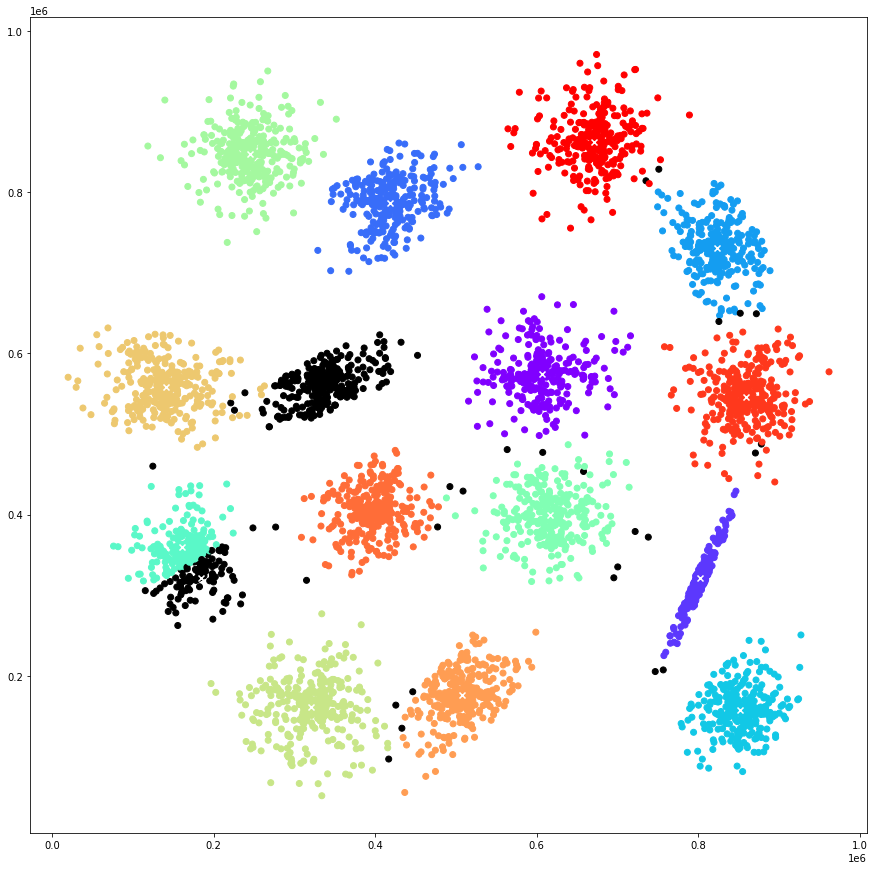

In [61]:

palette= plt.cm.rainbow(np.linspace(0,1,k))
centroids1 =result["Centroids"]
plt.figure(figsize=(15,15))
plt.scatter (dataset[:][:,0],dataset[:][:,1],color = [palette[int(result["Labels"][i])-1] if result["Labels"][i] == true_label[i] else (0,0,0,1) for i in range (0,dataset.shape[0])])
for j in range(k):
    plt.scatter(centroids1[j,0],centroids1[j,1],color = 'w',marker='x')  

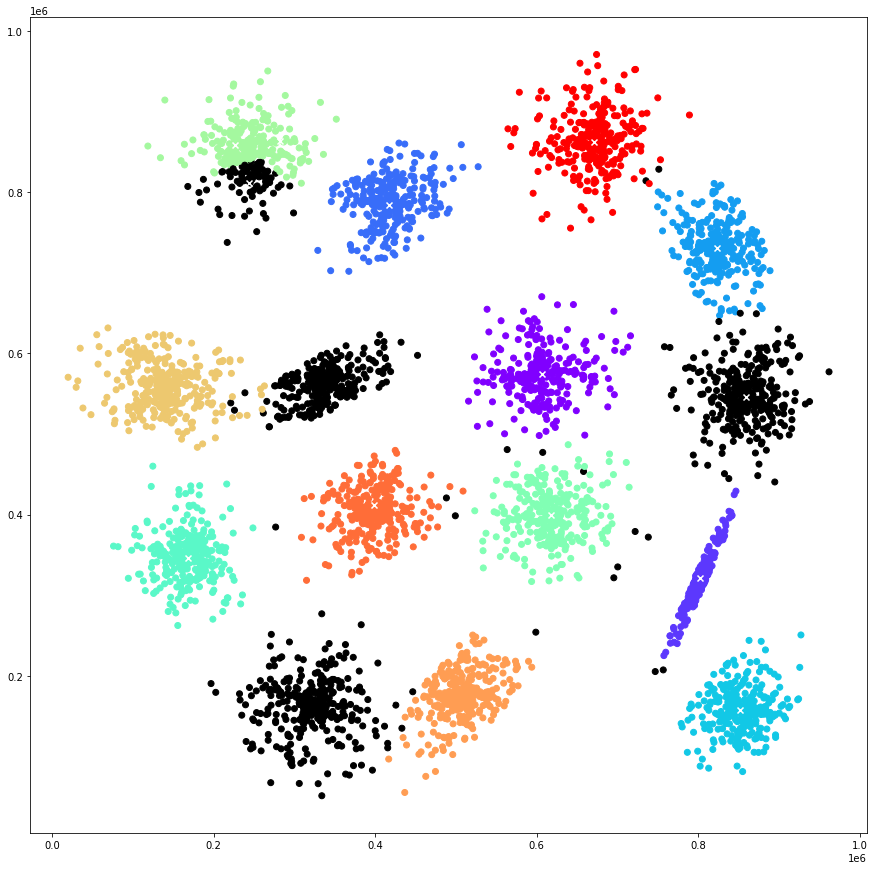

In [62]:
plt.figure(figsize=(15,15))
plt.scatter (dataset[:][:,0],dataset[:][:,1],color = [palette[int(kmeans_result["Labels"][i])-1] if int(kmeans_result["Labels"][i]) == int(true_label[i]) else (0,0,0,1) for i in range (0,dataset.shape[0])])
for j in range(k):
    plt.scatter(kmeans_result["Centroids"][j,0],kmeans_result["Centroids"][j,1],color = 'w',marker='x')  

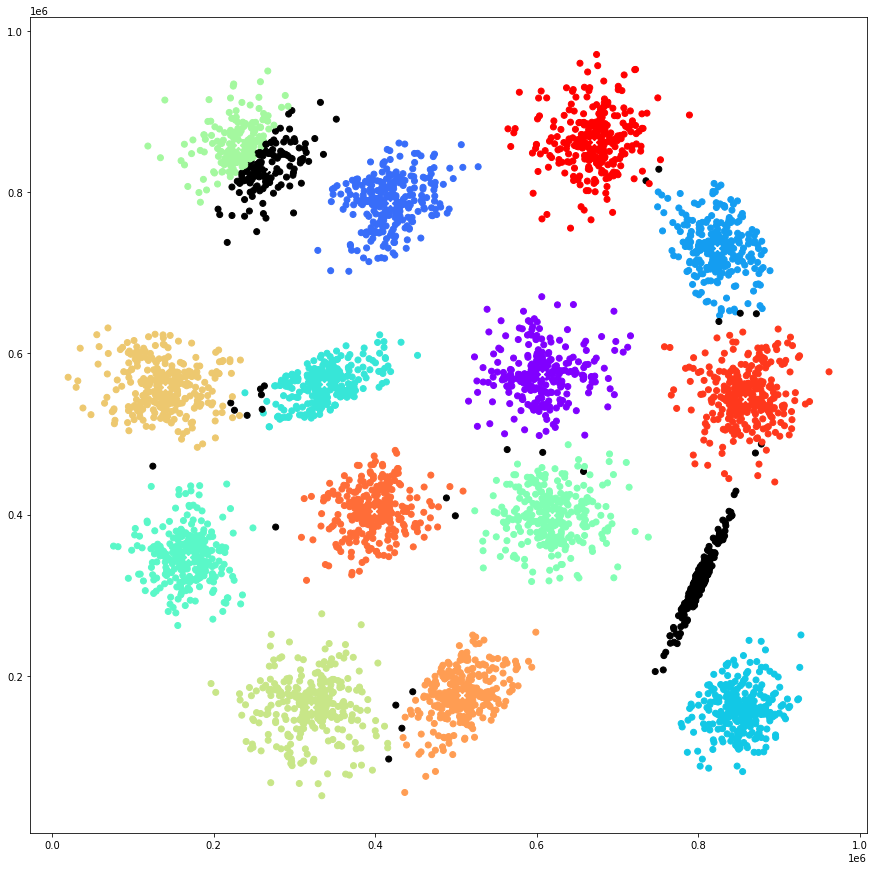

In [63]:
plt.figure(figsize=(15,15))
plt.scatter (dataset[:][:,0],dataset[:][:,1],color = [palette[int(kmeanspluplus_result["Labels"][i])-1] if int(kmeanspluplus_result["Labels"][i]) == int(true_label[i]) else (0,0,0,1) for i in range (0,dataset.shape[0])])
for j in range(k):
    plt.scatter(kmeanspluplus_result["Centroids"][j,0],kmeanspluplus_result["Centroids"][j,1],color = 'w',marker='x')  

In [67]:
#test for dataset#2
dataset1 = np.loadtxt ("dim064.txt")
k = 16
true_label1 = np.loadtxt ("dim064_label.txt")
dataset1.shape[0]

1024

In [71]:
time1 = time.time()
centroid = dataset1[np.random.choice(range(dataset1.shape[0]), k, replace=False),:]
kmeans_result = KMeans (dataset1,k,centroid)
time2 = time.time()
print ("Kmean took",time2-time1,"seconds to compute")
time1 = time.time()
kmeanspluplus_result = KMeansPlusPlus(dataset1,k)
kmeanspluplus_result = KMeans (dataset1,k,kmeanspluplus_result)
time2 = time.time()
print ("Kmeanplusplus took",time2-time1,"seconds to compute")
time1 = time.time()
result = ScalableKMeansPlusPlus (dataset1,k,k*3)
result = KMeans (dataset1,k,result)
time2 = time.time()
print ("scalable Kmeanplusplus took",time2-time1,"seconds to compute")
time1 = time.time()
parallelresult = ScalableKMeansPlusPlus_p (dataset1,k,k*3)
time2 = time.time()
parallelresult = KMeans (dataset1,k,parallelresult)
time3 = time.time()
print ("parallel scalable Kmeanplusplus took",(time2-time1)/10 + (time3-time2),"seconds to compute")

Converge! after: 2 iterations
Kmean took 0.18546724319458008 seconds to compute
Converge! after: 1 iterations
Kmeanplusplus took 0.20546865463256836 seconds to compute
Converge! after: 2 iterations
scalable Kmeanplusplus took 0.650810956954956 seconds to compute
Converge! after: 3 iterations
parallel scalable Kmeanplusplus took 0.2116548776626587 seconds to compute


In [72]:
print("Clustering Cost:")
print("Random:", clusterCost(dataset1, kmeans_result)) # Random 
print("KMeans++:",clusterCost(dataset1, kmeanspluplus_result)) # KMeans++
print("Scalable KMeans++:", clusterCost(dataset1, result)) # Scalable KMeans++

Clustering Cost:
Random: 6934.347621530828
KMeans++: 21.699353125
Scalable KMeans++: 2693.08271708416


In [75]:
accrate,convert = accuracyRate(true_label1,result,k)
print ("The accuracy of scalable kmeans ++ is ",accrate)
accrate,convert = accuracyRate(true_label1,kmeans_result,k)
print ("The accuracy of kmeans is ",accrate)
accrate,convert = accuracyRate(true_label1,kmeanspluplus_result,k)
print ("The accuracy of kmeans++ is ",accrate)

The accuracy of scalable kmeans ++ is  0.9892578125
The accuracy of kmeans is  0.98046875
The accuracy of kmeans++ is  1.0


In [140]:
dyataset1 = np.loadtxt ("letter-recognition.data" ,usecols = (1,16) ,delimiter = ",")
dataset1 = preprocessing.scale(dataset1)
label = np.loadtxt ("letter-recognition.data",dtype = 'str' ,usecols = (0) ,delimiter = ",")
k=26
truelabel = np.zeros ((label.shape))
for i in range(truelabel.shape[0]):
    truelabel[i] = ord(label[i])-64
truelabel = truelabel.astype(np.int)    

In [141]:
time1 = time.time()
centroid = dataset1[np.random.choice(range(dataset1.shape[0]), k, replace=False),:]
kmeans_result = KMeans (dataset1,k,centroid)
time2 = time.time()
print ("Kmean took",time2-time1,"seconds to compute")
time1 = time.time()
kmeanspluplus_result = KMeansPlusPlus(dataset1,k)
kmeanspluplus_result = KMeans (dataset1,k,kmeanspluplus_result)
time2 = time.time()
print ("Kmeanplusplus took",time2-time1,"seconds to compute")
time1 = time.time()
result = ScalableKMeansPlusPlus (dataset1,k,k*3)
result = KMeans (dataset1,k,result)
time2 = time.time()
print ("scalable Kmeanplusplus took",time2-time1,"seconds to compute")
time1 = time.time()
parallelresult = ScalableKMeansPlusPlus_p (dataset1,k,k*3)
time2 = time.time()
parallelresult = KMeans (dataset1,k,parallelresult)
time3 = time.time()
print ("parallel scalable Kmeanplusplus took",(time2-time1)/10 + (time3-time2),"seconds to compute")

Converge! after: 6 iterations
Kmean took 8.150180101394653 seconds to compute
Converge! after: 6 iterations
Kmeanplusplus took 8.826411485671997 seconds to compute
Converge! after: 5 iterations
scalable Kmeanplusplus took 8.292815923690796 seconds to compute
Converge! after: 7 iterations
parallel scalable Kmeanplusplus took 9.37973141670227 seconds to compute


In [142]:
print("Clustering Cost:")
print("Random:", clusterCost(dataset1, kmeans_result)) # Random 
print("KMeans++:",clusterCost(dataset1, kmeanspluplus_result)) # KMeans++
print("Scalable KMeans++:", clusterCost(dataset1, result)) # Scalable KMeans++

Clustering Cost:
Random: 0.2693417188186365
KMeans++: 0.25161820056526074
Scalable KMeans++: 0.24471685647834157


In [143]:
accrate,convert = accuracyRate(truelabel,result,k)
print ("The accuracy of scalable kmeans ++ is",accrate)
accrate,convert = accuracyRate(truelabel,kmeans_result,k)
print ("The accuracy of kmeans is",accrate)
accrate,convert = accuracyRate(truelabel,kmeanspluplus_result,k)
print ("The accuracy of kmeans++ is",accrate)

The accuracy of scalable kmeans ++ is 0.16415
The accuracy of kmeans is 0.17455
The accuracy of kmeans++ is 0.1804


In [131]:
dataset2 = np.loadtxt ("bank.csv" ,dtype = 'str',usecols = range(15) ,delimiter = ";")[1:]
#dataset1 = preprocessing.scale(dataset1)
labels = np.loadtxt ("bank.csv",dtype = 'str' ,usecols = (16) ,delimiter = ";")[1:]
k = 2

In [132]:
labels[labels =='"no"' ] = 0
labels[labels =='"yes"' ] = 1
truelabel =  labels.astype(np.int) 

In [133]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit (dataset2)
dataset2 = enc.transform(dataset2).toarray()

In [136]:
dataset2.shape
k=2

In [137]:
time1 = time.time()
centroid = dataset2[np.random.choice(range(dataset2.shape[0]), k, replace=False),:]
kmeans_result = KMeans (dataset2,k,centroid)
time2 = time.time()
print ("Kmean took",time2-time1,"seconds to compute")
time1 = time.time()
kmeanspluplus_result = KMeansPlusPlus(dataset2,k)
kmeanspluplus_result = KMeans (dataset2,k,kmeanspluplus_result)
time2 = time.time()
print ("Kmeanplusplus took",time2-time1,"seconds to compute")
time1 = time.time()
result = ScalableKMeansPlusPlus (dataset2,k,k*3)
result = KMeans (dataset2,k,result)
time2 = time.time()
print ("scalable Kmeanplusplus took",time2-time1,"seconds to compute")
time1 = time.time()
parallelresult = ScalableKMeansPlusPlus_p (dataset2,k,k*3)
time2 = time.time()
parallelresult = KMeans (dataset2,k,parallelresult)
time3 = time.time()
print ("parallel scalable Kmeanplusplus took",(time2-time1)/10 + (time3-time2),"seconds to compute")

Converge! after: 9 iterations
Kmean took 4.5857439041137695 seconds to compute
Converge! after: 15 iterations
Kmeanplusplus took 7.463061571121216 seconds to compute


MemoryError: Unable to allocate 2.38 GiB for an array with shape (4521, 19, 3714) and data type float64

In [139]:
#accrate,convert = accuracyRate(truelabel,result,k)
#print ("The accuracy of scalable kmeans ++ is",accrate)
accrate,convert = accuracyRate(truelabel,kmeans_result,k)
print ("The accuracy of kmeans is",accrate)
accrate,convert = accuracyRate(truelabel,kmeanspluplus_result,k)
print ("The accuracy of kmeans++ is",accrate)

The accuracy of kmeans is 0.583941605839416
The accuracy of kmeans++ is 0.583941605839416
